In [19]:
from pathlib import Path
import torch
import numpy as np
import pandas as pd
import imgaug
from imgaug.augmentables.bbs import BoundingBox

In [25]:
class CardiacDatset(torch.utils.data.Dataset):
    def __init__(self, path_to_labels, patients, root, augs):
        super().__init__()
        self.labels = pd.read_csv(path_to_labels)
        self.patients = np.load(patients)
        self.root_path = Path(root)
        self.augment = augs

    def __len__(self):
        return len(self.patients)
    
    def __getitem__(self, idx):
        patient = self.patients[idx]
        data = self.labels[self.labels["name"]==patient]

        x_min = data["x0"].item()
        y_min = data["y0"].item()
        x_max= x_min  + data["w"].item()
        y_max = y_min + data["h"].item()
        bbox = [x_min, y_min, x_max, y_max]

        file_path = self.root_path/patient
        img = np.load(f"{file_path}.npy").astype(np.float32)

        if self.augment: # to check if we are in the training or the validation dataset, we only augment training data
            bb = BoundingBox(x1 = bbox[0], y1 = bbox[1], x2 = bbox[2], y2 = bbox[3])
            random_seed = torch.randint(0,100000, (1,)).item()
            imgaug.seed(random_seed)

            img, aug_bbox = self.augment(image=img, bounding_boxes = bb)
            bbox = aug_bbox[0][0], aug_bbox[0][1], aug_bbox[1][0], aug_bbox[1][1]

        img = (img- 0.494)/0.252
        img = torch.Tensor(img).unsqueeze(0)
        bbox = torch.tensor(bbox)
        return img, bbox

In [26]:
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [27]:
seq = iaa.Sequential([
    iaa.GammaContrast(),
    iaa.Affine(
        scale = (0.8,1.2),
        rotate = (-10,10),
        translate_px=(-10,10))
])

In [28]:
labels_path = "rsna_heart_detection.csv"
patients_path = "Processed_Heart/train_subjects.npy"
train_root = "Processed_Heart/train/"
dataset= CardiacDatset(labels_path, patients_path,train_root, seq)

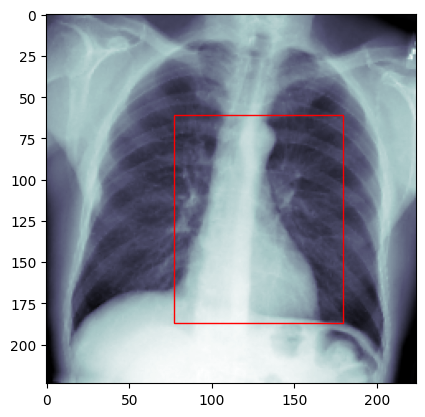

In [39]:
img, bbox = dataset[0]

fig, axis = plt.subplots(1,1)
axis.imshow(img[0], cmap= 'bone')
rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], edgecolor= 'r', facecolor ='none')
axis.add_patch(rect)